# Statistical Test for the CLIPScore

In this notebook the CLIPScore will be computed and compared on human and non-human annotated captions. The goal is to understand if the CLIPScore is able to catch the difference in the annotation process that took to the production of the captions. If it is able to do that, than the score is a valid metric to understand how much the captions fit the artworks.

In [48]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from transformers import CLIPModel, CLIPProcessor
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import scipy

In [14]:
PROJECT_DIR = Path(os.getcwd()).resolve().parent
DATA_DIR = PROJECT_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
IMAGES_DIR = RAW_DATA_DIR / "images"

In [3]:
df_captions = pd.read_csv(RAW_DATA_DIR / "artgraph_captions.csv")
df_captions

,image,name,caption,human
0,leonardo-da-vinci_mona-lisa.jpg,Mona Lisa; Leonardo da Vinci,The artwork depicts a woman with a mysterious ...,y
1,henri-de-toulouse-lautrec_in-bed-the-kiss-1892...,"In Bed, The Kiss; Henri de Toulouse-Lautrec",The artwork depicts a couple in bed sharing a ...,y
2,sandro-botticelli_the-birth-of-venus-1485.jpg,The Birth of Venus; Sandro Botticelli,The artwork depicts a naked woman standing on ...,y
3,claude-monet_madame-monet-and-child.jpg,Camille Monet and a Child in the Artist’s Gard...,The artwork depicts a woman and child in a gar...,y
4,gustav-klimt_the-kiss-1908.jpg,The Kiss; Gustav Klimt,"The artwork depicts a couple embracing, surrou...",y
...,...,...,...,...
116470,alexander-ivanov_via-appia-1845.jpg,Via Appia; Alexander Ivanov,The artwork depicts a scene from the Via Appia...,n
116471,alexander-ivanov_portrait-of-vittoria-marini.jpg,Portrait of Vittoria Marini; Alexander Ivanov,The artwork depicts a young woman with curly h...,n
116472,alexander-ivanov_olive-trees.jpg,Olive trees; Alexander Ivanov,The artwork depicts a group of olive trees on ...,n
116473,alexander-ivanov_annunciation-1824.jpg,Annunciation; Alexander Ivanov,The artwork depicts an angel with outstretched...,n


In [4]:
# load CLIP
model_url = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_url)
processor = CLIPProcessor.from_pretrained(model_url)

For the test, the captions will be divided into human and not-human annotated captions.

In [6]:
df_hcaptions = df_captions[df_captions["human"] == "y"][["image", "caption"]]
df_nhcaptions = df_captions[df_captions["human"] == "n"][["image", "caption"]]

Compare sets of captions of the same size, by excluding the non-human captions.

In [7]:
df_nhcaptions = df_nhcaptions.sample(len(df_hcaptions), random_state=42)
df_nhcaptions

,image,caption
99973,louise-elisabeth-vigee-le-brun_self-portrait-w...,The artwork depicts Mrs Vigee-Lebrun and her d...
38014,thomas-dewing_a-musician-1877.jpg,The artwork depicts a woman playing a stringed...
32308,ferdinand-hodler_farewell-participating-female...,The artwork depicts a female figure saying far...
88919,william-h-johnson_still-life-flowers-1938.jpg,The artwork depicts a vase with several colorf...
60925,charles-turner_william-wallis-1810-1.jpg,The artwork depicts a portrait of a man with s...
...,...,...
100281,vasily-surikov_krasnoyarsk-kachinskaya-street-...,The artwork depicts Kachinskaya street in Kras...
63816,benjamin-west_choice-of-hercules-between-virtu...,The artwork depicts the choice of Hercules bet...
41754,thomas-eakins_portrait-of-dr-horatio-c-wood.jpg,"The artwork depicts Dr. Horatio C Wood, who is..."
9436,pierre-auguste-renoir_young-girl-slipping-on-h...,The artwork depicts a young girl seated on a b...


The prefix "The artwork depicts" will be removed from the captions.

In [8]:
def remove_prefix(s):
    words = s.split()
    return " ".join(words[3:])

df_hcaptions["caption"] = df_hcaptions["caption"].apply(remove_prefix)
df_nhcaptions["caption"] = df_nhcaptions["caption"].apply(remove_prefix)
df_hcaptions

,image,caption
0,leonardo-da-vinci_mona-lisa.jpg,"a woman with a mysterious smile, sitting in fr..."
1,henri-de-toulouse-lautrec_in-bed-the-kiss-1892...,a couple in bed sharing a passionate kiss.
2,sandro-botticelli_the-birth-of-venus-1485.jpg,"a naked woman standing on a shell on the sea, ..."
3,claude-monet_madame-monet-and-child.jpg,"a woman and child in a garden, surrounded by t..."
4,gustav-klimt_the-kiss-1908.jpg,"a couple embracing, surrounded by a golden mos..."
...,...,...
495,juan-gris_harlequin-with-guitar-1919.jpg,a Cubist-style Harlequin figure playing a guit...
496,tintoretto_paradise.jpg,"a sprawling, heavenly scene filled with angels..."
497,jean-honore-fragonard_the-stolen-kiss-1788.jpg,"a romantic, clandestine moment between two lov..."
498,frederic-leighton_the-fisherman-and-the-syren-...,a tender encounter between a fisherman and a b...


Prepare the captions for the CLIP model.

In [12]:
h_captions = df_hcaptions["caption"].tolist()
nh_captions = df_nhcaptions["caption"].tolist()

In [13]:
h_embeddings = np.empty((1, 512))
nh_embeddings = np.empty((1, 512))

for i in tqdm(range(0, len(h_captions), 4)):
    batch_hcaptions = h_captions[i : min(i+4, len(h_captions))]
    batch_nhcaptions = nh_captions[i : min(i+4, len(h_captions))]
    h_inputs = processor(text=batch_hcaptions, images=None, return_tensors="pt", padding=True)
    nh_inputs = processor(text=batch_nhcaptions, images=None, return_tensors="pt", padding=True)
    h_features = model.get_text_features(**h_inputs)
    nh_features = model.get_text_features(**nh_inputs)
    h_embeddings = np.concatenate(
        (h_embeddings, h_features.detach().numpy()), axis=0
    )
    nh_embeddings = np.concatenate(
        (nh_embeddings, nh_features.detach().numpy()), axis=0
    )

100%|██████████| 125/125 [00:31<00:00,  3.95it/s]


In [15]:
filenames = sorted(os.listdir(IMAGES_DIR))
filenames

['a-mishra_expression-of-sadness-i.jpg',
 'a-mishra_expression-of-sadness-ii.jpg',
 'a-mishra_expression-of-sadness-iii.jpg',
 'a-mishra_why.jpg',
 'a-y-jackson_a-copse-evening-1918.jpg',
 'a-y-jackson_algoma-in-november-1935.jpg',
 'a-y-jackson_barns-1926.jpg',
 'a-y-jackson_early-spring-quebec-1923.jpg',
 'a-y-jackson_entrance-to-halifax-harbour-1919.jpg',
 'a-y-jackson_first-snow-algoma-country-1920.jpg',
 'a-y-jackson_frozen-lake-early-spring-algonquin-park-1914.jpg',
 'a-y-jackson_grey-day-laurentians-1928.jpg',
 'a-y-jackson_hills-at-great-bear-lake-1953.jpg',
 'a-y-jackson_houses-st-urbain-1934.jpg',
 'a-y-jackson_indian-home-1927.jpg',
 'a-y-jackson_maple-woods-algoma-1920.jpg',
 'a-y-jackson_march-storm-georgian-bay-1920.jpg',
 'a-y-jackson_nellie-lake-1933.jpg',
 'a-y-jackson_night-pine-island-1921.jpg',
 'a-y-jackson_north-shore-lake-superior-1926.jpg',
 'a-y-jackson_october-morning-algoma-wartz-lake-1920.jpg',
 'a-y-jackson_river-st-urbain-1930.jpg',
 'a-y-jackson_st-john-s

In [31]:
image_embeddings = np.load(PROCESSED_DATA_DIR / "clip_embeddings.npy")
image_embeddings = image_embeddings[1:,:]

In [32]:
h_indices = df_hcaptions["image"].apply(lambda x: filenames.index(x)).tolist()
nh_indices = df_nhcaptions["image"].apply(lambda x: filenames.index(x)).tolist()

In [33]:
type(h_indices)

list

In [34]:
h_img_embeddings = image_embeddings[h_indices, :]
nh_img_embeddings = image_embeddings[nh_indices, :]

In [36]:
h_embeddings = h_embeddings[1:,:]
nh_embeddings = nh_embeddings[1:,:]

In [42]:
h_scores = np.diagonal(cosine_similarity(h_img_embeddings, h_embeddings))
nh_scores = np.diagonal(cosine_similarity(nh_img_embeddings, nh_embeddings))

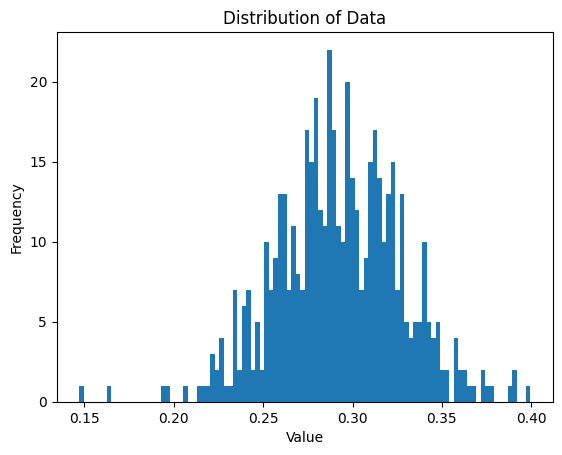

In [47]:
plt.hist(h_scores, bins=100)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

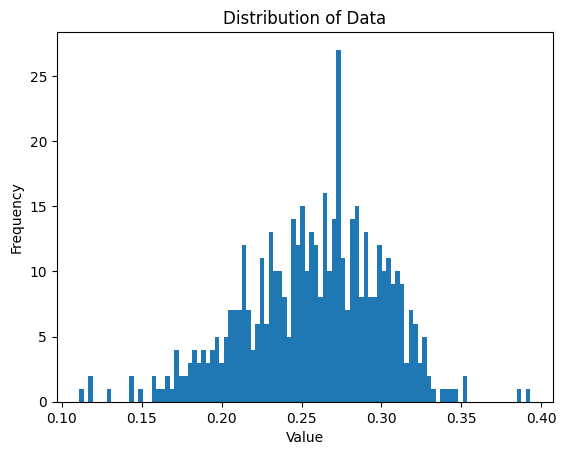

In [46]:
plt.hist(nh_scores, bins=100)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')

# Display the plot
plt.show()

In [53]:
np.var(nh_scores, ddof=1)

0.0018806703115900967

In [54]:
np.var(h_scores, ddof=1)

0.0012264852476270968

In [55]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
f_test(nh_scores, h_scores)

(1.53338192630418, 9.962850058276018e-07)

In [56]:
scipy.stats.ttest_ind(h_scores, nh_scores, equal_var=False)

Ttest_indResult(statistic=13.978004831878259, pvalue=1.5537191493900486e-40)